In this notebook -
https://github.com/bxin/scratchBook/blob/master/saturation_limit/satLim_exploreHeight.ipynb
I've calculated an LEOsat's apparent angular velocity as a function of height and zenith angle.

But -
The calculations I did to reproduce the angular velocity vs zenith angle plot - I assumed the satellite orbit goes through zenith.
If you think of a plane which the satellite resides in, which is perpendicular to the line of sight, to calculate the apparent angular velocity, we need to project the orbital velocity to that plane, then divide by the distance.
This is where the direction of the velocity vector matters. 
If it is coming toward zenith (coming toward us for example ), we multiply the velocity by cos(zenith angle) to get the projection to that plane (roughly speaking, in the limit of earth radius >> satellite height).
But if it is going perpendicular to the line of sight, the velocity vector is in that plane already, the projection to that plane is the velocity vector itself.

In [1]:
import numpy as np
import pandas as pd

In [2]:
G = 6.673e-11  #gravitational constant
Me = 5.97e24  #mass of earth in kg
Re = 6371e3  #radius of earth in m
heightKm = 550 #height in Km

If we know the Ra and Dec of two points on the trail, and also the Ra and Dec of zenith at the time of the observation, then we should be able calculate the proper projection.

However, it would be easier to do it another way. 
Meredith gave me Az/Alt for 2 points on each trail for the 2 visits with lowest and highest airmass.

<img src="./plots/cs1.png" alt="cs1" width="300"/>

P is the person (observer). The origin of the coordinate system is where the satellite is. 
Give the orbital velocity of a fixed magnitude, all the possible end point of the velocity vector forms a circle in a plane parallel to the ground right below it (not perfectly parallel with the group at P, but it is OK). The green line is the projection of that circle onto the x-z plane.

In [3]:
def calcAngularV(heightKm, zenithADeg, az1=0, alt1=0, az2=0, alt2=0):
    '''
    inputs: 
        heightM: satellite height in kilometers
        zenithADeg: zenith angle in degree
        alt1,az1, alt2, az2 are the alt/az of two points on the same trail
        when alt1, az1, alt2, az2 are not given, the orbit goes through zenith.
        when one of (alt1,az1, alt2, az2) is not zero, alt1,az1, alt2, az2 will be used for calculation.
    output:
        angular velocity as seen from earth, in deg per minute
    '''
    h=heightKm*1000 #height in meter
    za = np.radians(zenithADeg)
    omega = np.sqrt(G*Me/(Re+h)**3) #angular velocity as seen from center of earth
    orbitV = omega*(Re+h) #orbit velocity
    #the above is true irregardless of the observer
    
    #the below was derived when orbit goes through zenith; when it doesn't, calculations
    # of x and d are still valid. The velocity vector will be out of the plane formed by 
    # the satellite, observor, and center of the earth. But it is OK.
    x = np.arcsin(Re*np.sin(za)/(Re+h)) ## angle between line of sight and (Re+h)
    if np.isclose(x,0):
        d = h
    else:
        d = np.sin(za-x)*Re/np.sin(x) #distance between satellite and observer on earth
        
    #depending on the input parameters given:
    if (alt1 ==0 and alt2 ==0 and az1 ==0. and az2 == 0):
        tanV = orbitV*np.cos(x) #project orbitV to perpendicular to line of sight
        angleHorizon = 90
    else:
        tanTheta = (az2-az1)/(alt2-alt1)
        print('----tan(%.2f deg) = %.2f, min = %.2f, max=%.2f'%(
            np.degrees(np.arctan(tanTheta)), tanTheta,
             orbitV*np.cos(x)/d/np.pi*180*60, orbitV/d/np.pi*180*60))
        xSquare = 1./(1+np.tan(x)**2 + tanTheta**2)
        zSquare = xSquare*np.tan(x)**2
        tanV = orbitV*np.sqrt(1-zSquare)
        angleHorizon = 90 - abs(np.degrees(np.arctan(tanTheta)))
    angularV = tanV/d  #angular velocity as seen from earth
    angularV = angularV/np.pi*180*60  #convert from radian/sec into deg/min
    
    return angularV, angleHorizon

In [4]:
def getResults(az1, alt1, az2, alt2, X):
    results = dict()
    results['az1'] = az1
    results['alt1'] = alt1
    results['az2'] = az2
    results['alt2'] = alt2
    results['airmass'] = X
    zADeg = np.degrees(np.arccos(1/X))
    results['zenith angle (deg)'] = zADeg
    av, ah = calcAngularV(heightKm,zADeg, az1, alt1, az2, alt2)
    results['angle between trail and horizon (deg)'] = ah
    results['apparent angular velocity (deg/min)'] = av
    av0, ah0 = calcAngularV(heightKm,zADeg)
    results['if ignore velocity orientation'] = av0
    results['change (%)'] = (av-av0)/av0*100
    
    for key, value in results.items():
        results[key] = np.round(value, 2)
    return results

In [5]:
#additional info about the measurements from
# https://github.com/dirac-institute/starlink/blob/master/Starlink-Take1.ipynb

airmass = np.array([1.03, 1.15, 1.55, 1.55, 1.71])
#_1102
az1, alt1 = 315.42590939, 76.78503409
az2, alt2 = 314.55083988, 76.79906491
r1102 = getResults(az1, alt1, az2, alt2, airmass[0])
#_1073
az1, alt1 = 308.75906338, 59.44928046
az2, alt2 = 308.34745752, 59.44576393 
r1073 = getResults(az1, alt1, az2, alt2, airmass[1])
#_1130
az1, alt1 = 307.35108473, 39.70540244
az2, alt2 = 307.08128749, 39.70397097
r1130 = getResults(az1, alt1, az2, alt2, airmass[2])
#_1112
az1, alt1 = 308.18198551, 40.31105008
az2, alt2 = 307.91457617, 40.31140916
r1112 = getResults(az1, alt1, az2, alt2, airmass[3])
#_1084
az1, alt1 = 298.08830172, 71.61069403
az2, alt2 = 297.47051653, 71.57651103
r1084 = getResults(az1, alt1, az2, alt2, airmass[4])
frame = {'Sat 1102': r1102, 'Sat 1073': r1073, 'Sat 1130': r1130, 'Sat 1112': r1112, 'Sat 1084': r1084}
DF = pd.DataFrame(frame)

----tan(-89.08 deg) = -62.37, min = 45.01, max=46.15
----tan(89.51 deg) = 117.05, min = 37.19, max=41.76
----tan(89.70 deg) = 188.48, min = 22.90, max=32.22
----tan(-89.92 deg) = -744.71, min = 22.90, max=32.22
----tan(86.83 deg) = 18.07, min = 19.77, max=29.72


In [6]:
DF

,Sat 1102,Sat 1073,Sat 1130,Sat 1112,Sat 1084
az1,315.43,308.76,307.35,308.18,298.09
alt1,76.79,59.45,39.71,40.31,71.61
az2,314.55,308.35,307.08,307.91,297.47
alt2,76.80,59.45,39.70,40.31,71.58
airmass,1.03,1.15,1.55,1.55,1.71
zenith angle (deg),13.86,29.59,49.82,49.82,54.21
angle between trail and horizon (deg),0.92,0.49,0.30,0.08,3.17
apparent angular velocity (deg/min),46.15,41.76,32.22,32.22,29.66
if ignore velocity orientation,45.01,37.19,22.90,22.90,19.77
change (%),2.52,12.27,40.67,40.67,50.06


We want to make a plot like before, but with the orbit not going through zenith. Because for the same satellite the apparent angle on the sky keeps changing, we cannot use the alt1, az1, alt2, az2 as input variables. 

Instead of picturing all these planes and lines in 3D, which makes my head hurt -
#### We are going to take a numerical approach. 
Computationally the numerical approach is slower, but it is less error-prone, and saves human time.

In [7]:
from sympy import Point3D, Line3D, Plane
import matplotlib.pyplot as plt

In [8]:
def numAngularV(heightKm, alphaDeg, thetaDeg):
    '''
    input parameters:
        alphaDeg: angle between (earth center-observatory)^(orbital plane), in degree
        thetaDeg: azimuth angle of satellite inside the orbital plane. Max zenith angle gives thetaDeg = 0
        heightKm: satellite height in Km
    output:
        angularV: apparent angular velocity in deg/min
        zAnlgeDeg: zenith angle in degree
    '''
    
    #origin = earth center
    #+z = points up
    #+y = points out of paper
    #+x = points left
    # orbital plane is in z-y plane
    # observatory has positive x and positive z

    h = heightKm*1000
    if np.isclose(thetaDeg, 360):
        thetaDeg = 0
    alpha = np.radians(alphaDeg) #angle between (earth center-observatory)^(orbital plane)
    theta = np.radians(thetaDeg) #azimuth angle inside the orbital plane
    pt_obs = Point3D(Re*np.sin(alpha),0, Re*np.cos(alpha)) #point, observatory
    pl_orb = Plane((0,0,0), (0,0,1), (0,1,0)) #plane, orbit
    pt_sat = Point3D(0, (Re+h)*np.sin(theta), (Re+h)*np.cos(theta)) #point, satellite
    #print(pt_obs, pt_sat)
    
    pl_proj = Plane(pt_sat, normal_vector = (pt_sat - pt_obs)) #plane, plane for projecting velocity vector to
    omega = np.sqrt(G*Me/(Re+h)**3) #angular velocity as seen from center of earth
    orbitV = omega*(Re+h) #orbit velocity
    pt_v = Point3D(0, pt_sat.y + orbitV*np.cos(theta), pt_sat.z  - orbitV*np.sin(theta)) #point, tip of velocity vector

    #print(pl_proj, pt_v)
    #print(pl_proj.projection(pt_v))
    tanV = pt_sat.distance(pl_proj.projection(pt_v)).evalf() #project orbit velocity onto pl_proj
    d = pt_obs.distance(pt_sat).evalf() #distance between obserer and satellite
    #print(thetaDeg, orbitV, tanV, d)
    
    angularV = tanV/d  #angular velocity as seen from earth
    angularV = angularV/np.pi*180*60  #convert from radian/sec into deg/min
    
    ln_los = Line3D(pt_obs, pt_sat) #line, line of sight
    pl_obs = Plane(pt_obs, normal_vector = pt_obs) #plane, representing observatory floor
    ln_orb = Line3D((0,0,0), pt_sat) #line, for satellite,inside orbit plane
    zAngleDeg = 90 - np.degrees(np.float(pl_obs.angle_between(ln_los).evalf()))

    return angularV, zAngleDeg

0
1
2
3
4
5


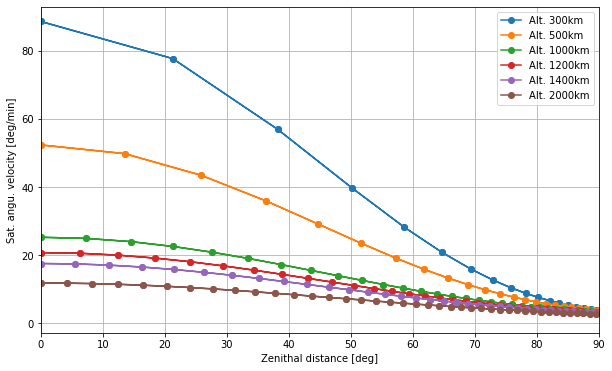

In [9]:
# this takes ~1 minute for each curve (each height value) on my MBP
npt = 361 #7 #361 #361
av = np.zeros((6,npt))
zas = np.zeros((6,npt))
thetas = np.linspace(0,360,npt)
hs = [i*1000 for i in [300,500,1000,1200,1400,2000]]
fig, ax = plt.subplots(figsize=(10,6))
for hi,h in enumerate(hs):
    print(hi)
    for thetai, theta in enumerate(thetas):
        #print(thetai)
        av[hi, thetai], zas[hi, thetai] = numAngularV(h/1000, 0, theta)
    plt.plot(zas[hi,:], av[hi,:], '-o', label='Alt. %.0fkm'%(h/1000))
plt.legend()
plt.xlim([0, 90])
plt.xlabel('Zenithal distance [deg]')
plt.ylabel('Sat. angu. velocity [deg/min]')
plt.grid()
# This seems to match what we had before pretty well
# https://github.com/bxin/scratchBook/blob/master/saturation_limit/satLim_exploreHeight.ipynb

In [10]:
def maxZAngle2alpha_deg(heightKm, za):
    '''
    convert max zenith angle of a orbit to alpha, where alpha is the observatory angle defined as:
        draw a line from center of earth to the observatory, the angle between this line and the satellite orbit plane
    both angles are in degree.
    '''
    h = heightKm*1000
    x = np.arcsin(Re*np.sin(np.radians(za))/(Re+h)) ## angle between line of sight and (Re+h)
    return (np.degrees(x) - za)

0 -1.12079639000617
1 -2.5540511434020523
2 -5.127163549000244
3 -5.127163549000244
4 -5.904336191184498


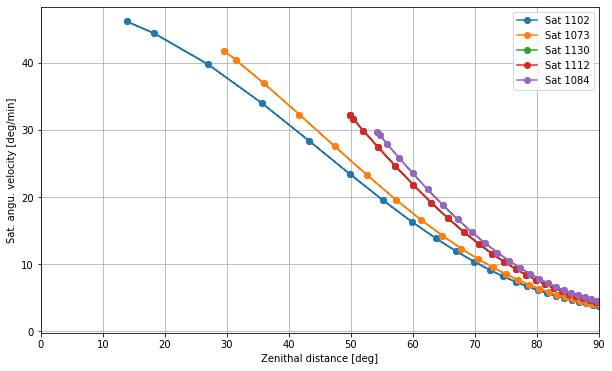

In [11]:
# this takes ~1 minute for each curve (each satellite trail) on my MBP
npt = 361 #361
av = np.zeros((5,npt))
zas = np.zeros((5,npt))
thetas = np.linspace(0,360,npt)
alphas = np.zeros(5)
for ii, i in enumerate(DF.keys()):
    alphas[ii] = maxZAngle2alpha_deg(heightKm, DF[i]['zenith angle (deg)'])
fig, ax = plt.subplots(figsize=(10,6))
for alphai, alpha in enumerate(alphas):
    print(alphai, alpha)
    for thetai, theta in enumerate(thetas):
        #print(thetai)
        av[alphai, thetai], zas[alphai, thetai] = numAngularV(heightKm, alpha, theta)
    plt.plot(zas[alphai,:], av[alphai,:], '-o', label=DF.keys()[alphai])
plt.legend()
plt.xlim([0, 90])
plt.xlabel('Zenithal distance [deg]')
plt.ylabel('Sat. angu. velocity [deg/min]')
plt.grid()

Seems to have found an issue in sympy

In [12]:
pp = Plane(Point3D(0, 0, 6671000), (0, 0, 300000))
pt = Point3D(0, 7727, 6671000)
pp.projection(pt)

Point3D(0, 7727, 6671000)

In [13]:
pp = Plane(Point3D(0, 0, 6671000), (0, 1e-9, 300000))
pt = Point3D(0, 7727, 6671000)
pp.projection(pt)

IndexError: list index out of range